# Final Project Code

In [84]:
import pandas as pd 
import numpy as np 
import h2o 
import re 
from h2o.targetencoder import TargetEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators import H2ORandomForestEstimator 
import matplotlib.pyplot as plt 
import nltk
import gensim
import seaborn as sns 
import string
import warnings 
warnings.filterwarnings('ignore') 
pd.options.display.float_format = '{:20.2f}'.format 
sns.set(font = "Computer Moder ", style = 'ticks')                                                                                                   

In [2]:
data = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD"

In [3]:
collisions = pd.read_csv(data)

In [4]:
h2o.init(max_mem_size = 10)    

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 day 22 hours 39 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,2 months and 2 days
H2O cluster name:,H2O_from_python_joevorbeck_qjvoph
H2O cluster total nodes:,1
H2O cluster free memory:,8.58 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [138]:
max_one_hot = 25       #Threshold for categorical data 
min_numerical = 300    #Threshold for numerical data    
test_size = .25      #Ratio for train/holdout  
dep_var =  "inj_death_ind" 
scaling_method = StandardScaler()  #Method for Scaling (MinMax, Standard, Etc.) 
seed = 1994 

In [6]:
#Check dataframe
collisions.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

In [7]:
collisions.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,02/03/2017,17:58,NaN,NaN,nan,nan,NaN,NaN,NaN,1852 RIVERSIDE DRIVE,...,Unspecified,NaN,NaN,NaN,3610711,TAXI,TAXI,NaN,NaN,NaN
1,02/03/2017,19:00,NaN,NaN,nan,nan,NaN,STATEN ISLAND EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,NaN,3611218,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN
2,05/12/2020,16:28,NaN,NaN,nan,nan,NaN,CROSS BRONX EXPY RAMP,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4313235,Sedan,Sedan,NaN,NaN,NaN
3,01/18/2014,10:10,NaN,NaN,40.61,-73.90,POINT (-73.8986633 40.6057453),NaN,NaN,NaN,...,Unspecified,NaN,NaN,NaN,2950386,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
4,02/03/2017,19:57,NaN,NaN,40.88,-73.85,POINT (-73.848755 40.88144),EAST 222 STREET,NaN,NaN,...,NaN,NaN,NaN,NaN,3609932,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN


# Text Analysis

In [89]:
#NLP - Looking at the streets of accidents
street_nlp = str(list(collisions['ON STREET NAME']))

In [90]:
#Normalize text
street_nlp = street_nlp.lower().split()

In [91]:
#Tokenize text
street_nlp_token = nltk.word_tokenize(str(street_nlp))

In [92]:
#As a note, dont want to lemmatize or stem words, these are street names / types

In [93]:
#Get list of punctuation to remove from set of strings
punc = string.punctuation

In [99]:
#Remove punctuation from strings
street_nlp_token_cleaned = [x for x in street_nlp_token if x not in [punc, "''", "``",",","'","[","]"]]

In [121]:
#Plot frequency distribution of top words 
fdist  = pd.DataFrame.from_dict(nltk.FreqDist(street_nlp_token_cleaned), orient = "index").reset_index().sort_values(by = 0, ascending = False)
fdist.rename(columns = {"index" : "word", 0 : "count"}, inplace = True)

In [123]:
#Drop Na row
fdist = fdist[fdist['word'] != "'nan"]

Text(0.5, 1.0, 'Top 10 Most Frequent Terms in Streets where MV Accidents Occured')

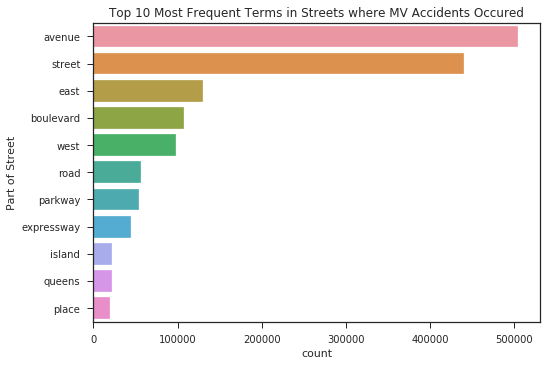

In [173]:
#Plot top 10 - looking for trends / patterns
sns.barplot(x = "count", y = "word", data = fdist[0:11], orient = "h").set(yticklabels = ["avenue","street","east","boulevard","west","road","parkway","expressway","island","queens","place"])
plt.ylabel("Part of Street")
plt.title("Top 10 Most Frequent Terms in Streets where MV Accidents Occured")


# Creating the Target and Dataset to be Pre-processed

In [132]:
#Create DV - Was 1 or more cyclists killed or injured?
def dv(x): 
    if x['NUMBER OF CYCLIST KILLED'] >= 1 or x['NUMBER OF CYCLIST INJURED'] >= 1: 
        val = 1 
    else: 
        val = 0 
    return val 

In [133]:
collisions[dep_var] = collisions.apply(dv, axis = 1)

In [134]:
#Remove rows where borough is empty (corresponds with a blank zipcode)
collisions = collisions[collisions['BOROUGH'].notnull()]

In [135]:
#Extract month and hour from cincident date to use as features
collisions['Month'] = pd.to_datetime(collisions['CRASH DATE']).dt.month
collisions['Hour'] = collisions['CRASH TIME'].str[0:2].str.replace(":","")

In [139]:
#Drop unwanted columns
collisions = collisions[["Month","Hour","BOROUGH","ZIP CODE","NUMBER OF PEDESTRIANS KILLED","NUMBER OF PEDESTRIANS INJURED","NUMBER OF MOTORIST KILLED", "NUMBER OF MOTORIST INJURED","CONTRIBUTING FACTOR VEHICLE 1","VEHICLE TYPE CODE 1", dep_var]]

## Descriptive Stats & Visualizations

In [170]:
#Count of the dv
dv_count = pd.DataFrame(collisions.groupby(dep_var)[dep_var].count())
dv_count.rename(columns = {dep_var : "count"}, inplace = True)
dv_count = dv_count.reset_index()

In [174]:
dv_count

,inj_death_ind,count
0,0,1138397
1,1,27455


Text(0.5, 1.0, 'Count of Bicycle Injury or Death Events')

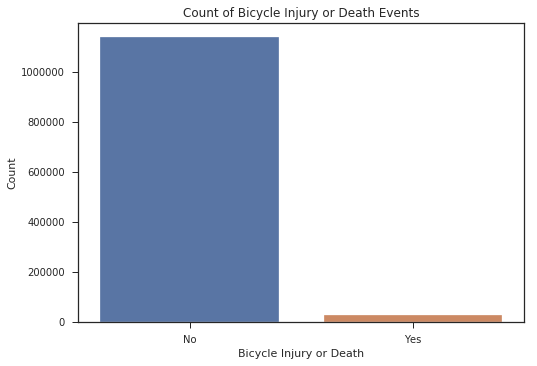

In [175]:
sns.barplot(x = dep_var, y = "count", data = dv_count).set(xticklabels=["No","Yes"])
plt.style.use('seaborn-notebook')
plt.xlabel("Bicycle Injury or Death")
plt.ylabel("Count")
plt.title("Count of Bicycle Injury or Death Events")

Text(0.5, 1.0, 'Count of Bicycle Injury or Death Events by Borough')

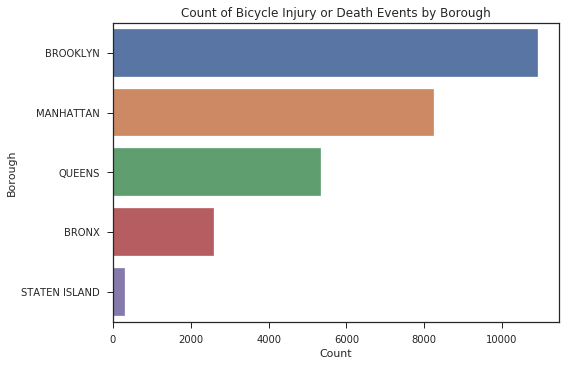

In [14]:
#Bicycle death or injury by borough
dv_borough = pd.DataFrame(collisions.groupby('BOROUGH')[dep_var].sum().reset_index()).sort_values(by = dep_var, ascending = False)
sns.barplot(x = dep_var, y = "BOROUGH", data = dv_borough, orient = "h")
plt.style.use('seaborn-notebook')
plt.xlabel("Count")
plt.ylabel("Borough")
plt.title("Count of Bicycle Injury or Death Events by Borough")

Text(0.5, 1.0, 'Count of Bicycle Injury or Death Events by Month')

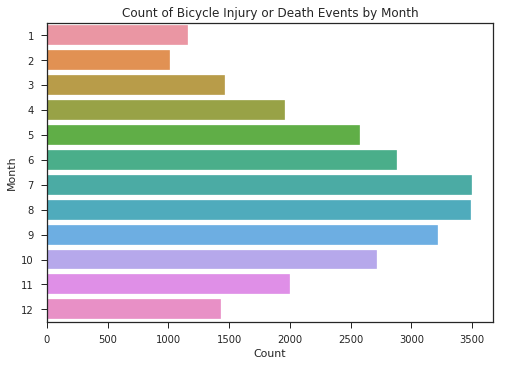

In [15]:
#Bicycle death or injury by month and hour
dv_month = pd.DataFrame(collisions.groupby('Month')[dep_var].sum().reset_index()).sort_values(by = dep_var, ascending = False)
sns.barplot(x = dep_var, y = "Month", data = dv_month, orient = "h")
plt.style.use('seaborn-notebook')
plt.xlabel("Count")
plt.ylabel("Month")
plt.title("Count of Bicycle Injury or Death Events by Month")

Text(0.5, 1.0, 'Count of Bicycle Injury or Death Events by Hour')

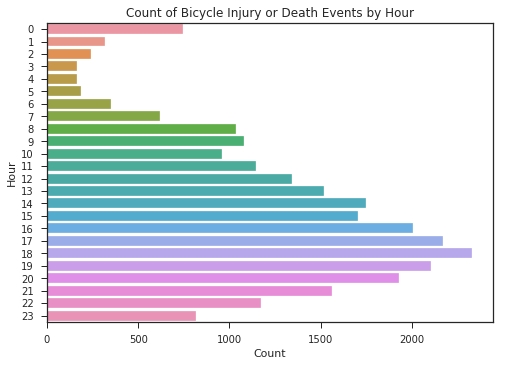

In [16]:
dv_hour = pd.DataFrame(collisions.groupby('Hour')[dep_var].sum().reset_index()).sort_values(by = "Hour", ascending = False)
dv_hour['Hour'] = dv_hour['Hour'].astype(int)
sns.barplot(x = dep_var, y = "Hour", data = dv_hour, orient = "h")
plt.style.use('seaborn-notebook')
plt.xlabel("Count")
plt.ylabel("Hour")
plt.title("Count of Bicycle Injury or Death Events by Hour")

Text(0.5, 1.0, 'Count of Bicycle Injury or Death Events by Cause of Incident - Top 10')

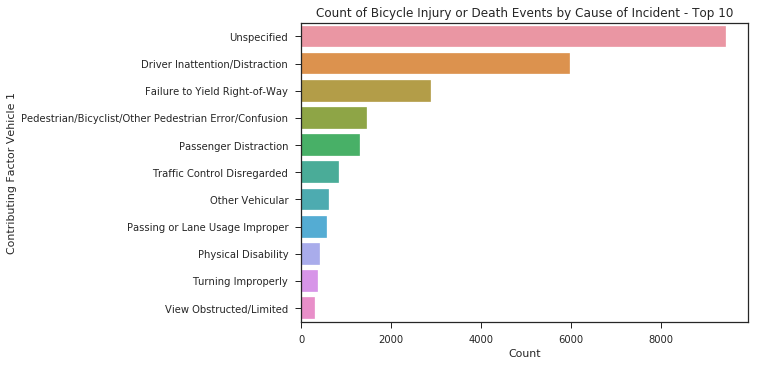

In [172]:
#Bicycle death or injury by main contributing factor - top 10
dv_vehicle = pd.DataFrame(collisions.groupby('CONTRIBUTING FACTOR VEHICLE 1')[dep_var].sum().reset_index()).sort_values(by = dep_var, ascending = False)[0:11]
sns.barplot(x = dep_var, y = 'CONTRIBUTING FACTOR VEHICLE 1', data = dv_vehicle, orient = "h")
plt.xlabel("Count")
plt.style.use('seaborn-notebook')
plt.ylabel("Contributing Factor Vehicle 1")
plt.title("Count of Bicycle Injury or Death Events by Cause of Incident - Top 10")

In [18]:
#Check cardinality 
low_card = list()
high_card = list()
numerical = list()
single_value = list()
all_na = list()

for col in collisions.columns:
    try:
        col_count_dist = collisions[col].nunique()
        if col_count_dist == 0:
            all_na.append(col)
        elif col_count_dist == 1:
            single_value.append(col)
        elif col_count_dist <= max_one_hot:
            low_card.append(col)
        elif col_count_dist > max_one_hot and col_count_dist <= min_numerical:
            high_card.append(col)
        elif col_count_dist > min_numerical:
            numerical.append(col)
    except:
        pass

# Create dataframes by cardinality

In [19]:
df_low_card = collisions[low_card].drop(dep_var, axis = 1)
df_high_card = collisions[high_card]
df_numerical = collisions[numerical]

# Find columns that are already binary - reduces redundancy in one hot encoding

In [20]:
#Find columns that are already binary - reduces redundancy in one hot encoding
already_binary = list()

for col in df_low_card.columns:
    try:
        col_min = df_low_card[col].min()
        col_max = df_low_card[col].max()
        if col_min == 0 and col_max == 1:
            already_binary.append(col)
    except:
        pass

In [21]:
# Dataframe of already binary columns - not found
df_binary = df_low_card[[already_binary]]

In [22]:
#Regex match on numerical data to see what is truly numerical or not - no numerical columns found
true_num = list()
true_high_card = list()

for col in df_numerical.columns:
    try:
        col_to_check = str(df_numerical[col].dropna().iloc[0])
        num_match = re.match("^[0-9]+$", col_to_check)
        if num_match:
            true_num.append(col)
        else:
            true_high_card.append(col)
    except:
        pass

In [200]:
df_low_card[["Month","NUMBER OF PEDESTRIANS KILLED", "NUMBER OF PEDESTRIANS INJURED", "NUMBER OF MOTORIST KILLED"]] = df_low_card[["Month","NUMBER OF PEDESTRIANS KILLED", "NUMBER OF PEDESTRIANS INJURED", "NUMBER OF MOTORIST KILLED"]].astype("object")


# One hot encode low cardinality columns 

In [201]:
#One hot encode low cardinality df
df_low_one_hot = pd.get_dummies(df_low_card)

# Target Encode High Cardinality Columns 

In [24]:
#Add high cardinality categorical data to the high card list and create a df
high_card.extend(true_high_card)

In [25]:
#Dataframe of true high cardinality data
df_true_high_card = collisions[high_card]

In [26]:
#Add target column for encoding
df_true_high_card[dep_var] = collisions[dep_var]

In [27]:
#Create train/test datasets for encoding
te_train, te_test = train_test_split(df_true_high_card, test_size = test_size, random_state = seed)

In [28]:
#Turn train and test set into h2o frames
te_train = h2o.H2OFrame(te_train).ascharacter().asfactor()
te_test = h2o.H2OFrame(te_test).ascharacter().asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [29]:
#Create a fold column
fold = te_train.kfold_column(n_folds=5, seed=seed)
fold.set_names(["fold"])

te_train = te_train.cbind(fold)
te_train["fold"] = te_train["fold"].asfactor()

In [30]:
#Set list of columns to encode - drop DV & fold from variable list
x = list(te_train.columns)
x = [i for i in x if i not in [dep_var, "fold"]]

In [31]:
#Initialize target encoder and fit to training set
target_encoder = TargetEncoder(x = x, y = dep_var,
                               fold_column="fold",
                               blended_avg= True,
                               inflection_point = 3,
                               smoothing = 1,
                               seed=seed)
target_encoder.fit(te_train)

In [32]:
#Transform training set
encoded_train = target_encoder.transform(frame=te_train, holdout_type="kfold", noise=0.2, seed=seed)

#Transform test set
encoded_test = target_encoder.transform(frame=te_test, holdout_type="none", noise=0.0, seed=seed)

In [33]:
#Union two sets backtogther and convert back to df
df_high_card_te = encoded_train.drop("fold", axis = 1).rbind(encoded_test)
df_high_card_te = df_high_card_te.as_data_frame()

In [34]:
#Drop untransformed columns
df_high_card_te.drop(x, axis = 1, inplace=True)

# Join Processed DataFrames Together for Modeling 

In [203]:
#Join dataframes together
df_ml = pd.concat([df_low_one_hot, df_high_card_te], axis = 1)

In [206]:
#Model
#Turn final dataset into an h2o frame
df_converted = h2o.H2OFrame(df_ml)

Parse progress: |█████████████████████████████████████████████████████████| 100%


# Create train & holdout sets

In [207]:
#Create train/holdout sets
df_test, df_train = df_converted.split_frame(ratios = [test_size], seed = seed)

In [208]:
#Isolate IVs
features = [x for x in df_test.columns if x not in [dep_var]]

In [209]:
#Convert DV to factor
df_train[dep_var] = df_train[dep_var].asfactor()

# Initialize Random Forest Grid Search

In [210]:
#RF hyperparameters - gridsearch on tree depth and n trees
drf_params = {'max_depth': [3, 5, 10],
                   'ntrees': [50, 100, 200]}

In [213]:
#Initialize rf grid search
drf_grid = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='drf_grid2',
                          hyper_params=drf_params)

In [214]:
#Run grid search - certain parameters kept constant
drf_grid.train(features, 
               dep_var, 
               training_frame = df_train, 
               seed = seed, 
               balance_classes = True, 
               sample_rate = .75,
               stopping_metric = "logloss",
               col_sample_rate_per_tree = 1)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


# Model Results 

In [215]:
#Extract best model from grid search
drf_list = drf_grid.get_grid(sort_by='auc', decreasing=True)
drf_best = drf_list.models[0]

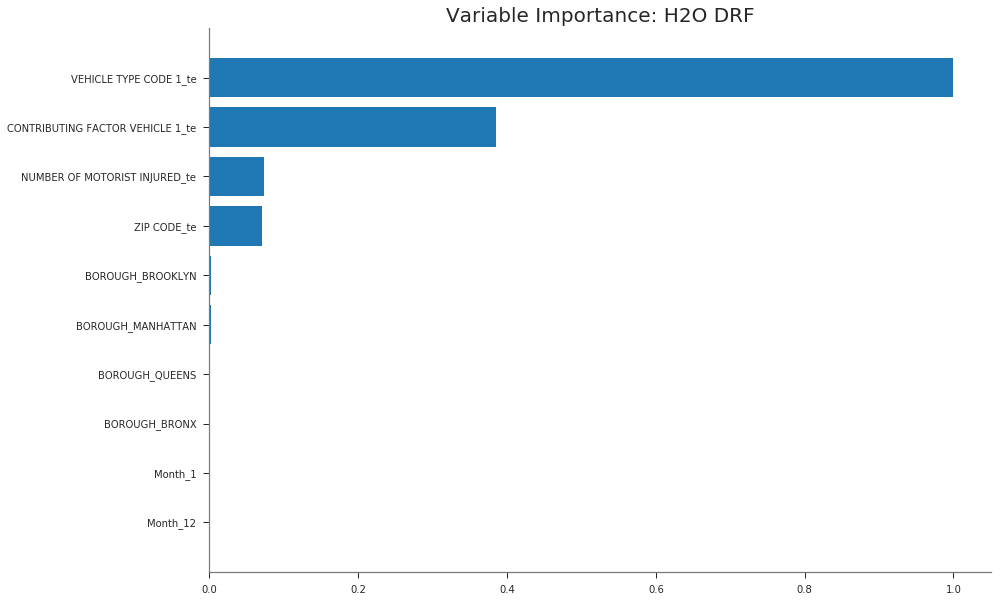

In [216]:
#Top Variables
drf_best.varimp_plot()

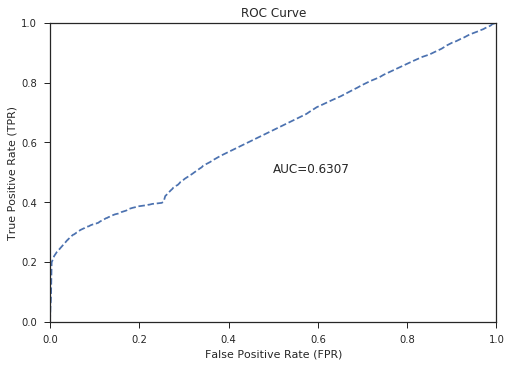


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.029848256028920918: 


,,0,1,Error,Rate
0,0,283571.00,948.00,0.0033,(948.0/284519.0)
1,1,5528.00,1359.00,0.8027,(5528.0/6887.0)
2,Total,289099.00,2307.00,0.0222,(6476.0/291406.0)


In [217]:
#Test set performance - AUC and Predictions
model_perf = drf_best.model_performance(df_test)
model_perf.plot(type = "roc")
model_perf.confusion_matrix()

In [218]:
#Accuracy
print("Accuracy: " + str((283571 + 1359) / (283571 + 1359 + 948 + 5528)))
#Precision
print("Precision: " + str(1359 / (1359 + 5528)))
#Recall
print("Recall: " + str(1359/(1359+948)))

Accuracy: 0.9777767101569631
Precision: 0.19732829969507767
Recall: 0.5890767230169051


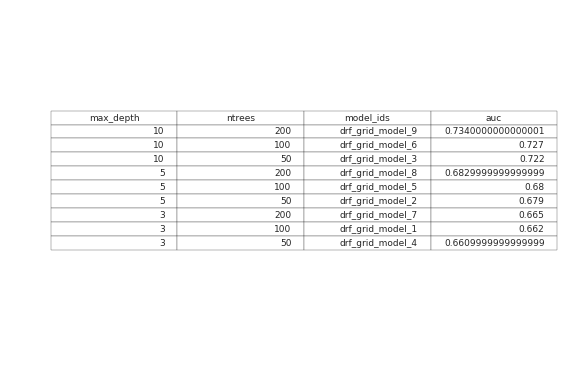

In [219]:
#Models in order of best to worst in csv - read back in to make a nicer table - for showing which model was used for test set predictions
models = pd.read_csv("models.csv")
fig, ax = plt.subplots()

#hide axes
ax.axis('off')
ax.axis('tight')
fig.patch.set_visible(True)

ax.table(cellText=models.values, colLabels=models.columns, loc='center')

fig.tight_layout()

plt.show()